In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

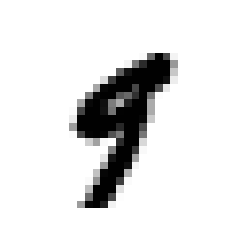

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

'9'

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
import numpy as np
shuffle_index = np.random.permutation(60000)
shuffle_index

array([33027, 42512, 45305, ..., 40268, 17521, 21202])

In [10]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [11]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits.
y_test_5 = (y_test == '5')
y_train_5

array([False, False,  True, ...,  True, False, False])

In [12]:
y = y.astype(np.uint8)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([False])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9668
0.9628
0.96695


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96655, 0.9659 , 0.9688 ])

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53792,   787],
       [ 1188,  4233]], dtype=int64)

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8432270916334661

In [20]:
recall_score(y_train_5, y_train_pred)

0.780852241283896

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8108418733837754

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-5673.90848057])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [24]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

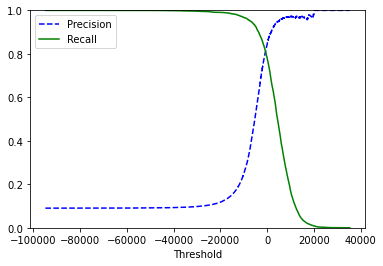

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [29]:
threshold_90_precision

1741.696494820733

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9001472031403337

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.6768123962368566

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

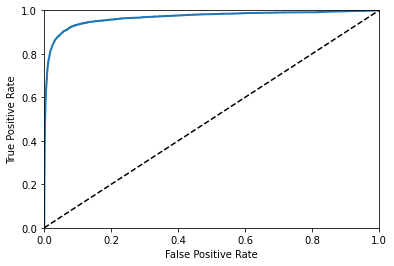

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9671891794539963

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [36]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

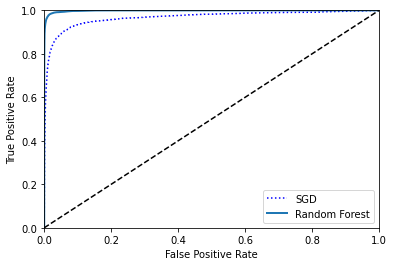

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984690733221574

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9897102057958841

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8693967902600996

In [41]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-29443.57816811, -17727.95951045, -17493.45063733,
         -2203.90797183,  -5307.48220929,  -6447.56710863,
        -38102.32617774,  -3838.31255933,  -4432.05615611,
         -8039.92252198]])

In [43]:
np.argmax(some_digit_scores)


3

In [44]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [45]:
sgd_clf.classes_[3]

'3'

In [46]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['4'], dtype=object)

In [47]:
len(ovo_clf.estimators_)

45

In [48]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

In [49]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.  , 0.08, 0.02, 0.01, 0.04, 0.01, 0.84]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87925, 0.8829 , 0.85495])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

c:\python\python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90005, 0.903  , 0.8916 ])

In [54]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring ='accuracy')

array([0.9643 , 0.96555, 0.9661 ])

In [53]:
X_train_scaled


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])